In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, \
                            auc,\
                            f1_score, \
                            recall_score, \
                            precision_score, \
                            classification_report

In [2]:
n_samples=1500
n_features=2
data = make_classification(n_samples=n_samples,
                           n_classes=2,
                           n_features=n_features,
                           n_clusters_per_class=1,
                           n_informative=n_features, 
                           n_redundant=0, 
                           n_repeated=0,
                           flip_y=0.0,
                           random_state=42
                          )
feature_cols = [f'x{i}' for i in range(1,n_features+1)]
X = pd.DataFrame(data[0], columns = feature_cols)
y = pd.DataFrame(data[1], columns = ['y'])
df = pd.concat([X, y], axis=1)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
print(df_train.shape)
df.head(3)

(1050, 3)


,x1,x2,y
0,-2.799877,-0.136802,0
1,-1.367893,1.101364,0
2,-1.372660,0.543190,0


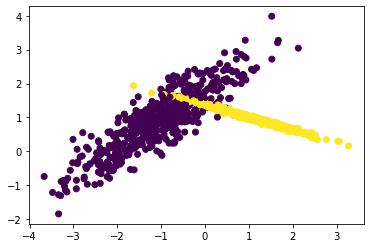

In [3]:
pl.scatter(df_train['x1'], df_train['x2'], c=df_train['y'])

In [4]:
def prepare_U_L_data(df, in_label_col, out_label_col, u_frac):
    """ Mask a fraction of labels to make unlabeled dataset 
        input:
        df: dataframe 
        l_frac: fraction of labeled dataset
        u_frac: fraction of unlabeled dataset
        in_label_col: str, name of input target column
        out_label_col: str, name of output target column
    """
    if (u_frac < 0.) | (u_frac > 1.0) :
        print("Error: u_frac must be between 0 and 1")
    df_u = df.sample(frac=u_frac).copy()
    df_l = df[~df.index.isin(df_u.index)].copy()
    print(df_u.shape)
    print(df_l.shape)
    df_u.loc[:, out_label_col] = -1
    df_l.loc[:, out_label_col] = df_l.loc[:, in_label_col]
    return pd.concat([df_u, df_l])

In [5]:
def data_sampler(df: pd.DataFrame,
                 label_column='label',
                 l_frac=1.,
                 u_frac=0.1):
    """ Return fraction ofd data for label and unlabel dataset to study effect of 
        portion of labeled and unlabeled dataset on performance of a trained model. 
        
        input:
        df: dataframe with collection of both labeled and unlabeled data. The unlabeled
        data are specified with label -1
        l_frac: desired fraction of labeled dataset
        u_frac: desired fraction of unlabeled dataset
    """
    df_u = df[df[label_column] == -1 ]
    df_l = df[df[label_column] != -1]
    
    df_u_sample = df_u.sample(frac=u_frac)
    df_l_sample = df_l.sample(frac=l_frac)
    
    return pd.concat([df_u_sample, df_l_sample])
    

In [6]:
def evaluate_model(true_label, predicted_label):
    """ Report classification reports """
    
    fs = f1_score(true_label, predicted_label)
    pc = precision_score(true_label, predicted_label)
    rc = recall_score(true_label, predicted_label)
    roc = roc_auc_score(true_label, predicted_label)

    return {'f1': fs, "precision":pc, "recall":rc, "roc":roc}

In [7]:
def self_trainer(ml_trainer, 
                 feature_cols, 
                 target_col, 
                 df_train,
                 df_test,
                 l_frac, 
                 u_frac, 
                 n_realization):
    fs = []; pc = []; rc = []; roc = []
    for i in range(n_realization): # loop on realizations
        df_aux = data_sampler(df_train, target_col, l_frac=l_frac, u_frac=u_frac)
        ml_trainer.fit(df_aux[feature_cols], df_aux[target_col])
        test_prediction = ml_trainer.predict(df_test[feature_cols])
        
        metrics = evaluate_model(df_test[target_col], test_prediction)
        fs.append(metrics['f1'])
        pc.append(metrics['precision'])
        rc.append(metrics['recall'])
        roc.append(metrics['roc'])

    return np.mean(roc), np.std(roc)

In [8]:
df_out = prepare_U_L_data(df_train, 'y', 'y', 0.5)

(525, 3)
(525, 3)


In [9]:
df_out['y'].value_counts()

-1    525
 1    263
 0    262
Name: y, dtype: int64

In [10]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
cl_self = Pipeline([('self-clf', SelfTrainingClassifier(sgd, threshold=0.95))])

In [11]:
roc_scores = {}
roc_stds = {}
for l_frac in np.linspace(0.05, 1, 10):
    roc_scores[l_frac] = []
    roc_stds[l_frac] = []
    for u_frac in np.linspace(0.001, 1, 10):
        roc, roc_std = self_trainer(ml_trainer=cl_self, 
                           feature_cols=feature_cols,
                           target_col='y',
                           df_train=df_out,
                           df_test=df_test,
                           l_frac=l_frac, 
                           u_frac=u_frac, 
                           n_realization=10)
        roc_scores[l_frac].append(roc)
        roc_stds[l_frac].append(roc_std)

Text(0, 0.5, 'ROC Score')

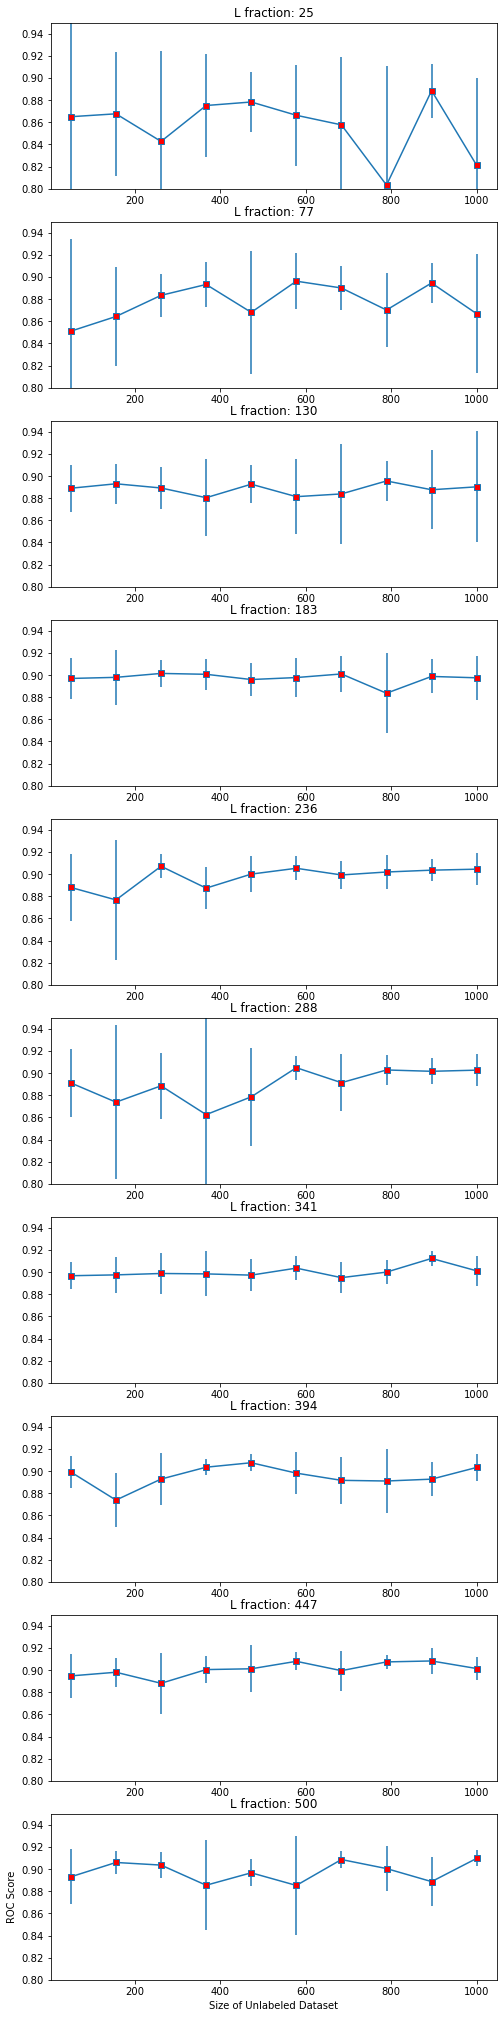

In [12]:
fig, ax = pl.subplots(10, 1, figsize=(8,36))
for i, k in enumerate(roc_scores.keys()):
    ax[i].errorbar(1000*np.linspace(0.05, 1, 10), roc_scores[k], roc_stds[k], marker='s', mfc='red')
    ax[i].set_title('L fraction: {:}'.format(int(k*500)))
    ax[i].set_ylim(0.8, 0.95)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('ROC Score')

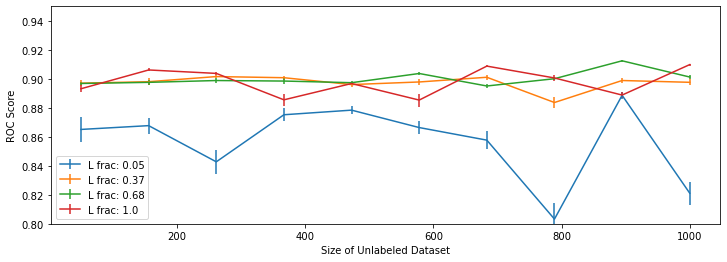

In [17]:
fig, ax = pl.subplots(1, 1, figsize=(12,4))
for i, k in enumerate(roc_scores.keys()):
    if i%3 == 0:
        ax.errorbar(1000*np.linspace(0.05, 1, 10), roc_scores[k], 
                    0.1*np.array(roc_stds[k]), label=f"L frac: {k:2.2}")
    
# ax.set_title('L fraction: {:}'.format(int(k*500)))
ax.set_ylim(0.8, 0.95)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('ROC Score')
pl.legend(loc='best')
pl.savefig("../figs/l_fraction.pdf")

### Effect of Prob. Threshold

In [14]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
roc_scores_ex2 = {}
roc_stds_ex2 = {}
for thrs in np.linspace(0.5, .99, 10):
    cl_self = Pipeline([('self-clf', SelfTrainingClassifier(sgd, threshold=thrs))])
    roc_scores_ex2[thrs] = []
    roc_stds_ex2[thrs] = []
    for u_frac in np.linspace(0.001, 1, 10):
        roc, roc_std = self_trainer(ml_trainer=cl_self, 
                           feature_cols=feature_cols,
                           target_col='y',
                           df_train=df_out,
                           df_test=df_test,
                           l_frac=l_frac, 
                           u_frac=u_frac, 
                           n_realization=20)
        roc_scores_ex2[thrs].append(roc)
        roc_stds_ex2[thrs].append(roc_std)

Text(0, 0.5, 'ROC Score')

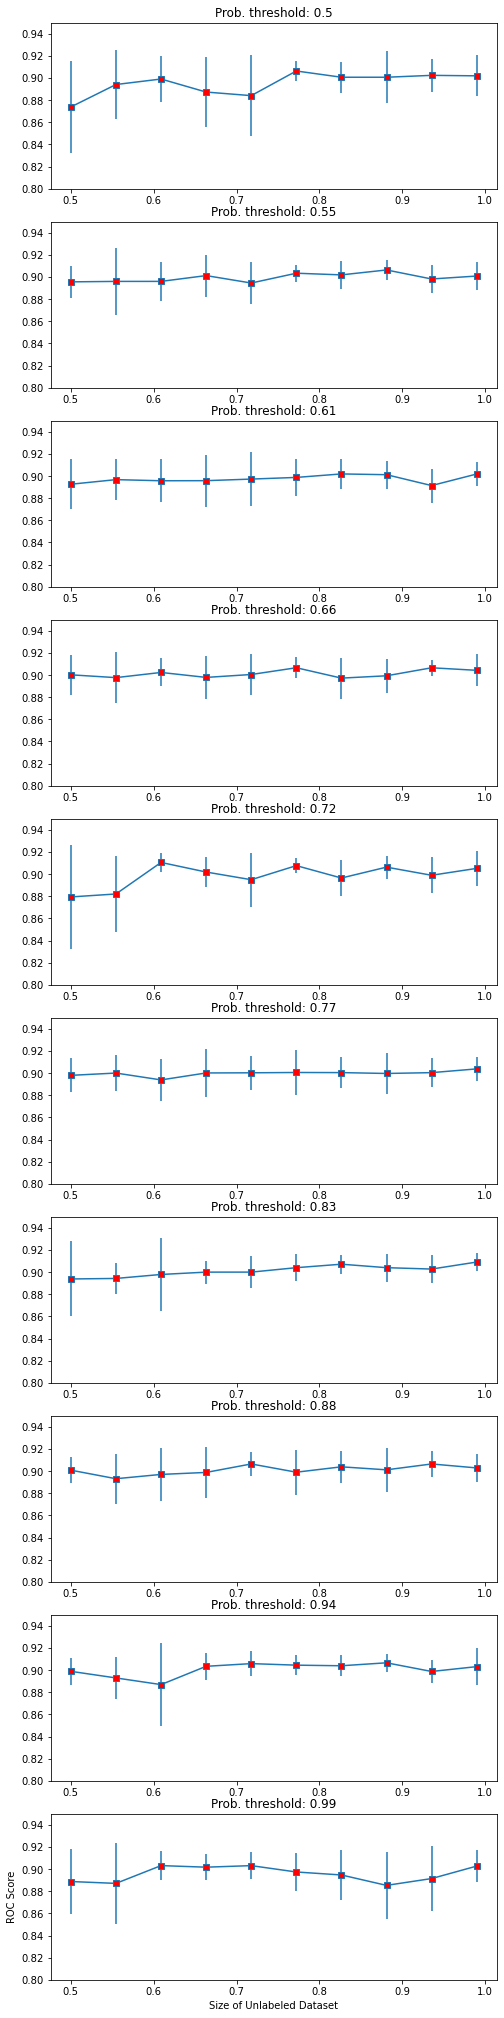

In [15]:
fig, ax = pl.subplots(10, 1, figsize=(8,36))
for i, k in enumerate(roc_scores_ex2.keys()):
    ax[i].errorbar(np.linspace(0.5, 0.99, 10), roc_scores_ex2[k], roc_stds_ex2[k], 
                   marker='s', 
                   mfc='red')
    ax[i].set_title('Prob. threshold: {:.2}'.format(k))
    ax[i].set_ylim(0.8, 0.95)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('ROC Score')

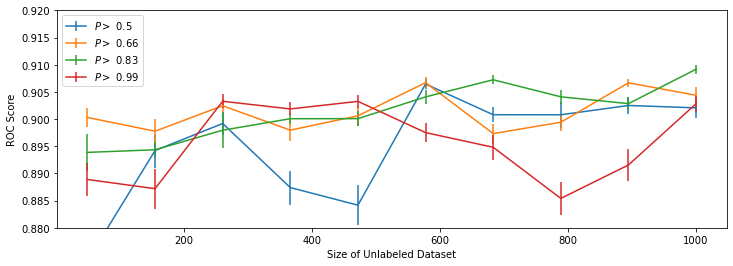

In [18]:
fig, ax = pl.subplots(1, 1, figsize=(12,4))
for i, k in enumerate(roc_scores_ex2.keys()):
    if i%3 == 0:
        ax.errorbar(1000*np.linspace(0.05, 1, 10), roc_scores_ex2[k], 
                    0.1*np.array(roc_stds_ex2[k]), label=r"$P > $ "+ f"{k:2.2}")
    
# ax.set_title('L fraction: {:}'.format(int(k*500)))
ax.set_ylim(0.88, 0.92)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('ROC Score')
pl.legend(loc='best')
pl.savefig("../figs/threshold.pdf")